In [1]:
!git clone -b binding --single-branch https://github.com/TienDat-BK/BTL-Extended-DSA.git

Cloning into 'BTL-Extended-DSA'...
remote: Enumerating objects: 2440, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 2440 (delta 13), reused 9 (delta 9), pack-reused 2413 (from 2)
Receiving objects: 100% (2440/2440), 16.83 MiB | 10.40 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [ ]:
get_ipython().system('rm -rf /content/BTL-Extended-DSA')

In [ ]:
!apt-get update
!apt-get install -y g++
!pip install pybind11


In [ ]:
get_ipython().system('rm -rf /content/BTL-Extended-DSA/HSmodule.cpython-312-x86_64-linux-gnu.so')

In [ ]:
%cd /content/BTL-Extended-DSA
!python setup.py build_ext --inplace

In [ ]:
!pip install sentence-transformers

In [5]:
from sentence_transformers import SentenceTransformer
import sys
sys.path.append('/content/BTL-Extended-DSA')
from HSmodule import *

In [ ]:
# Load model
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

def getEmbeddedVec(sentences):
  list_embedded_vec = model.encode(sentences)
  listVecRecord = []
  for i, vec in enumerate(list_embedded_vec):
    listVecRecord.append(VecRecord(vec = vec, id = i))
  return listVecRecord


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
!wget https://raw.githubusercontent.com/Brit7777/plagbench/refs/heads/main/plagbench_evaluation_set.csv -O dataset.csv

--2025-10-08 15:27:17--  https://raw.githubusercontent.com/Brit7777/plagbench/refs/heads/main/plagbench_evaluation_set.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306665 (1.2M) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   1.25M  --.-KB/s    in 0.006s  

2025-10-08 15:27:19 (206 MB/s) - ‘dataset.csv’ saved [1306665/1306665]



In [7]:
import pandas
df = pandas.read_csv('dataset.csv',  skiprows=0)

In [33]:
choied_columns = ["source_doc","susp_doc", "label"]

yes_label = df[df["label"] == 'yes' ][:400][choied_columns]
no_label = df[df["label"] == 'no' ][:400][choied_columns]

print(yes_label.shape)

(400, 3)


In [64]:
class SimHashModel():
  def __init__(self) -> None:
    self.embeding_model = SentenceTransformer('all-MiniLM-L6-v2')
    self.hasher = SimHash(InputDim = 384 , OutputDim = 128)
    self.searcher = Search();
    self.searcher.num_bands = 32
    self.searcher.threshold = 0.2
    self.searcher.setDisFunc("hamming")

  def getEmbeddedVec(self, sentences, cnt):
    list_embedded_vec = self.embeding_model.encode(sentences)
    listVecRecord = []
    for i, vec in enumerate(list_embedded_vec):
      listVecRecord.append(VectorRecord(vec = vec, id = cnt))
    return listVecRecord

  def eval(self, data):
    r, c = data.shape
    n = 0

    for i in range(r):
      label = data.iloc[i, 2]
      listVecRecord = self.getEmbeddedVec([data.iloc[i, 0], data.iloc[i, 1]], i)
      listVecRecord = self.hasher.hash(listVecRecord)
      ans = self.searcher.classifyByBand(listVecRecord)
      if len(ans) >= 2:
        ans = 'no'
      else:
        ans = "yes"

      if ans == label:
        n += 1
      # else :
      #   print("sai : ------------------------")
      #   print(data.iloc[i, 0])
      #   print(data.iloc[i, 1])
      #   print("--------------------------------")

    return n / r


In [66]:
a = SimHashModel()
print(a.eval(yes_label))

0.9425


In [58]:
def hammingDis( vec1, vec2):
  n = 0
  for i in range(len(vec1)):
    if vec1[i] != vec2[i]:
      n+=1

  return  1 -  n / len(vec1)


In [59]:
hasher = SimHash(384, 128 )
model = SentenceTransformer('all-MiniLM-L6-v2')
yeslistHamming = []

for index , row in yes_label.iterrows():
  embedVec = model.encode([row['source_doc'], row['susp_doc']], normalize_embeddings=True)
  embedVec = model.encode([row['source_doc'], row['susp_doc']])
  vecRecords = [
      VectorRecord(vec=embedVec[0], id=0),
      VectorRecord(vec=embedVec[1], id=1)
  ]

  # print(embedVec[0])
  # print(embedVec[1])
  hashVec = hasher.hash(vecRecords)
  # print(hashVec[0])
  # print(hashVec[1])
  # print("------------------------------------------")
  yeslistHamming.append(hammingDis(hashVec[0].vec, hashVec[1].vec))

labelForYes = [1] * len(yeslistHamming)
print(yeslistHamming)


[0.8984375, 1.0, 1.0, 1.0, 0.765625, 0.9609375, 0.828125, 1.0, 0.84375, 1.0, 0.8359375, 1.0, 0.8125, 1.0, 0.8125, 0.84375, 1.0, 0.8203125, 1.0, 0.9140625, 0.859375, 1.0, 1.0, 0.8359375, 0.7890625, 1.0, 0.828125, 1.0, 0.9140625, 0.8984375, 0.78125, 0.8828125, 0.859375, 0.8984375, 1.0, 0.953125, 0.921875, 0.984375, 0.78125, 0.8984375, 0.734375, 0.84375, 0.8515625, 0.90625, 1.0, 0.8125, 0.921875, 0.859375, 0.953125, 0.859375, 1.0, 0.859375, 0.90625, 0.9140625, 0.9296875, 0.890625, 0.90625, 1.0, 0.8984375, 1.0, 0.8125, 0.8515625, 1.0, 0.8046875, 0.8515625, 0.8203125, 0.9375, 1.0, 1.0, 0.8515625, 0.890625, 0.8515625, 0.9609375, 0.8203125, 0.9375, 0.8671875, 0.8046875, 0.921875, 0.796875, 0.8125, 0.84375, 0.8984375, 0.8984375, 1.0, 1.0, 0.9765625, 0.859375, 1.0, 1.0, 0.921875, 1.0, 0.9296875, 1.0, 1.0, 0.765625, 0.9296875, 0.8828125, 0.8203125, 1.0, 0.9765625, 0.8984375, 0.90625, 0.8125, 1.0, 0.8984375, 1.0, 1.0, 0.8984375, 1.0, 0.859375, 0.828125, 1.0, 0.9296875, 0.765625, 0.84375, 0.773437

In [60]:
hasher = SimHash(384, 128 )
model = SentenceTransformer('all-MiniLM-L6-v2')
nolistHamming = []

for index , row in no_label.iterrows():
  embedVec = model.encode([row['source_doc'], row['susp_doc']], normalize_embeddings=True)
  embedVec = model.encode([row['source_doc'], row['susp_doc']])
  vecRecords = [
      VectorRecord(vec=embedVec[0], id=0),
      VectorRecord(vec=embedVec[1], id=1)
  ]

  # print(embedVec[0])
  # print(embedVec[1])
  hashVec = hasher.hash(vecRecords)
  # print(hashVec[0])
  # print(hashVec[1])
  # print("------------------------------------------")
  nolistHamming.append(hammingDis(hashVec[0].vec, hashVec[1].vec))

labelForNo = [0] * len(nolistHamming)
print(nolistHamming)

[0.84375, 0.75, 0.7578125, 0.6171875, 0.71875, 0.7578125, 0.7734375, 0.65625, 0.828125, 0.6640625, 0.625, 0.6328125, 0.796875, 0.7578125, 0.71875, 0.7421875, 0.765625, 0.765625, 0.6953125, 0.8125, 0.703125, 0.6953125, 0.6171875, 0.65625, 0.7109375, 0.6640625, 0.6484375, 0.59375, 0.7265625, 0.7265625, 0.65625, 0.6953125, 0.6796875, 0.6640625, 0.734375, 0.7421875, 0.734375, 0.78125, 0.796875, 0.6953125, 0.625, 0.7578125, 0.6875, 0.796875, 0.7421875, 0.6484375, 0.7578125, 0.734375, 0.7890625, 0.734375, 0.796875, 0.8046875, 0.75, 0.6796875, 0.8671875, 0.640625, 0.78125, 0.734375, 0.6796875, 0.65625, 0.71875, 0.71875, 0.8125, 0.671875, 0.7265625, 0.75, 0.703125, 0.703125, 0.65625, 0.75, 0.8125, 0.609375, 0.5390625, 0.75, 0.7109375, 0.6171875, 0.890625, 0.7421875, 0.7265625, 0.59375, 0.6953125, 0.796875, 0.671875, 0.71875, 0.734375, 0.796875, 0.625, 0.6875, 0.734375, 0.7890625, 0.78125, 0.71875, 0.7421875, 0.6640625, 0.78125, 0.703125, 0.578125, 0.765625, 0.8359375, 0.75, 0.6796875, 0.710937

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def getProb(x):
  return 1 - (1 - x ** (128 / 64) ) ** 64

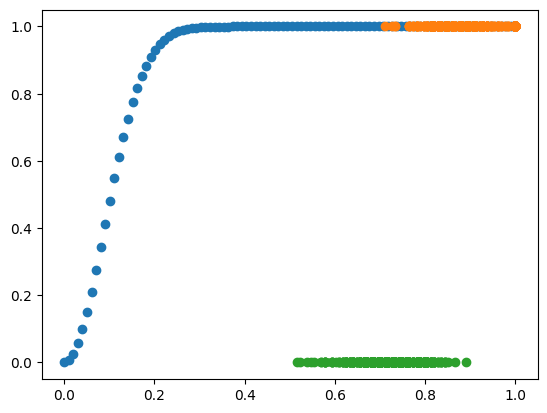

In [61]:
prob_x = np.linspace(0, 1 , 100)
prob_y = getProb(prob_x)
plt.scatter(prob_x, prob_y)
plt.scatter(yeslistHamming, labelForYes, linestyle='-')
plt.scatter(nolistHamming, labelForNo)
plt.show()